# **Imports**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import datetime
import google.colab
import numpy as np
from numpy import trapz

**Reading data from drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Heart rate simulated samples

In [3]:
path = r'/content/drive/MyDrive/heart_rate_samples/person_1/sample_594.csv'

df = pd.read_csv(path)
#df

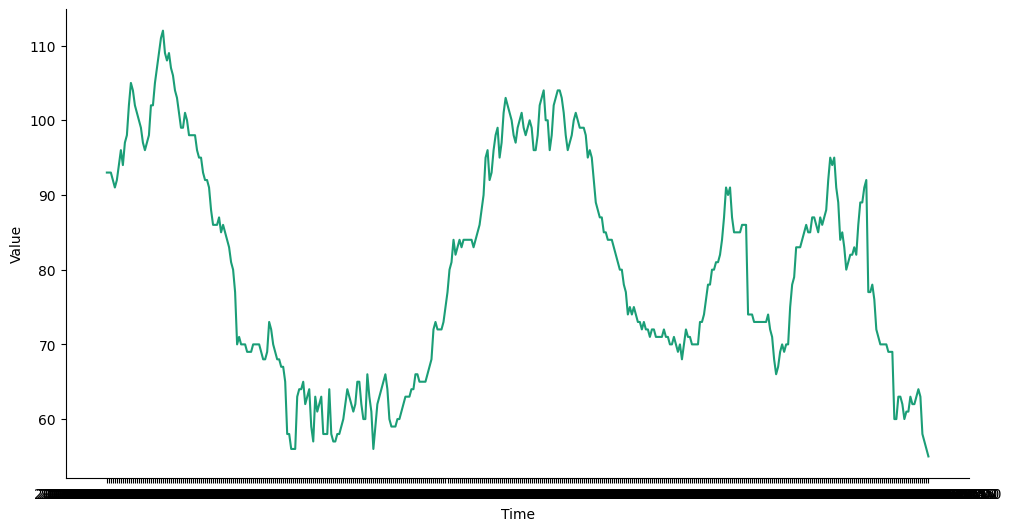

In [14]:
# @title Visualization
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['Value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('Value')

# Calculating features

In [7]:
'''# plot
plt.title("ECG signal - 1000 Hz")
plt.plot(df.Value[0:5000])
plt.xlabel('Time (milliseconds)')
plt.show()'''

'# plot\nplt.title("ECG signal - 1000 Hz")\nplt.plot(df.Value[0:5000])\nplt.xlabel(\'Time (milliseconds)\')\nplt.show()'

In [ ]:
'''# Parse time column if present
if 'Time' in df.columns:
    if pd.api.types.is_datetime64_any_dtype(df['Time']):  # Check if already datetime
        print("DataFrame is already in the correct format.")
    else:
        print("Converting 'Time' column to datetime and sorting DataFrame by time.")
        df['Time'] = pd.to_datetime(df['Time'])
        df.sort_values('Time', inplace=True)
else:
    print("DataFrame is already in the correct format.")


# Determine if data is raw ECG or already heart rate values
raw_ecg = False
if any(col.lower() == 'ecg' for col in df.columns):
    raw_ecg = True
    ecg_col = [c for c in df.columns if c.lower() == 'ecg'][0]
    ecg_signal = df[ecg_col].values
else:
    # If there's no ECG column, assume the data contains heart rate readings
    hr_values = df['Value'].astype(float).values if 'Value' in df.columns else df.iloc[:, -1].astype(float).values
    times = None
    if 'Time' in df.columns:
        times = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds().values
    else:
        # If no timestamps provided, assume data is uniformly sampled (e.g., 1 Hz)
        times = np.arange(len(hr_values), dtype=float)'''

'# Parse time column if present\nif \'Time\' in df.columns:\n    if pd.api.types.is_datetime64_any_dtype(df[\'Time\']):  # Check if already datetime\n        print("DataFrame is already in the correct format.")\n    else:\n        print("Converting \'Time\' column to datetime and sorting DataFrame by time.")\n        df[\'Time\'] = pd.to_datetime(df[\'Time\'])\n        df.sort_values(\'Time\', inplace=True)\nelse:\n    print("DataFrame is already in the correct format.")\n\n\n# Determine if data is raw ECG or already heart rate values\nraw_ecg = False\nif any(col.lower() == \'ecg\' for col in df.columns):\n    raw_ecg = True\n    ecg_col = [c for c in df.columns if c.lower() == \'ecg\'][0]\n    ecg_signal = df[ecg_col].values\nelse:\n    # If there\'s no ECG column, assume the data contains heart rate readings\n    hr_values = df[\'Value\'].astype(float).values if \'Value\' in df.columns else df.iloc[:, -1].astype(float).values\n    times = None\n    if \'Time\' in df.columns:\n       

#Load ECG signal

In [5]:
def load_ecg(csv_path):
    """
    Load ECG data from a CSV file.
    Returns the signal as a NumPy array and the inferred sampling rate (if possible).
    """
    df = pd.read_csv(csv_path)
    # If there's a column named 'Value', assume that's the ECG amplitude or RR interval series
    if 'Value' in df.columns:
        ecg_signal = df['Value'].values
    else:
        # If CSV has a single column of ECG values without header
        ecg_signal = df.iloc[:, 0].values

    # Infer sampling rate if time or uniform index is available
    sampling_rate = None
    if 'Time' in df.columns:
        time_col = pd.to_datetime(df['Time'], errors='coerce')
        # Compute median interval in seconds if possible
        if time_col.notna().all():
            time_deltas = time_col.diff().dt.total_seconds().dropna().values
            if len(time_deltas) > 0:
                median_interval = np.median(time_deltas)
                if median_interval > 0:
                    sampling_rate = 1.0 / median_interval  # Hz
    return ecg_signal, sampling_rate

# Load the ECG signal from file
ecg_signal, fs = load_ecg(path)
print(f"Loaded ECG signal of length {len(ecg_signal)}. Inferred sampling rate: {fs}")

Loaded ECG signal of length 411. Inferred sampling rate: 0.2


#R-Peak detection

In [6]:
def detect_r_peaks(ecg_signal, sampling_rate=None):
    """
    Detect R-peak indices from an ECG signal.
    Returns an array of R-peak indices (positions in the signal).
    """
    # If NeuroKit2 is available, use it for robust peak detection
    if nk is not None and sampling_rate is not None:
        # Clean the ECG signal (bandpass filter)
        ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
        # Detect R-peaks – returns a dict with key "ECG_R_Peaks"
        peaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
        r_peaks = peaks_info[1]['ECG_R_Peaks']
    else:
        # Fallback: simple approach using SciPy find_peaks
        signal = ecg_signal - np.mean(ecg_signal)  # Remove DC offset
        distance = max(1, int(0.3 * sampling_rate)) if sampling_rate else 1  # Ensure at least 1
        r_peaks, _ = find_peaks(signal, distance=distance, height=np.std(signal))
    return np.array(r_peaks, dtype=int)

# Detect R-peaks
r_peaks = detect_r_peaks(ecg_signal, sampling_rate=fs if fs else 1000)
print(f"Detected {len(r_peaks)} R-peaks.")

NameError: name 'nk' is not defined

#R-R Interval handaling

In [ ]:
import numpy as np

# Calculate RR intervals from R-peaks
if len(r_peaks) > 1:
    if fs:
        # If sampling rate is known, convert sample differences to milliseconds
        rr_intervals_ms = np.diff(r_peaks) / fs * 1000.0  # in ms
    else:
        # If sampling rate not known (e.g., input was already RR intervals), use the values as given
        rr_intervals_ms = np.diff(r_peaks)  # might already be in ms if peaks are timestamps
    print(f"Computed {len(rr_intervals_ms)} RR-intervals (ms).")
else:
    rr_intervals_ms = np.array([])
    print("Not enough R-peaks detected to compute RR-intervals.")


Computed 15 RR-intervals (ms).


In [ ]:
from scipy.stats import zscore

def clean_rr_intervals(rr_intervals_ms):
    """Replace outlier RR intervals (e.g., >2 std devs) with median to mitigate artifacts."""
    if len(rr_intervals_ms) == 0:
        return rr_intervals_ms
    rr = rr_intervals_ms.copy()
    # Identify outliers using z-score
    outliers = np.abs(zscore(rr)) > 2
    rr[outliers] = np.median(rr)
    return rr

cleaned_rr = clean_rr_intervals(rr_intervals_ms)

#Compure HRV Features

##Time domain features

In [ ]:
def compute_time_domain_features(rr_ms):
    """
    Compute time-domain HRV features from a sequence of RR intervals in milliseconds.
    Returns a dictionary of feature names and values.
    """
    rr = np.asarray(rr_ms)
    features = {}
    if len(rr) < 1:
        return features  # Not enough data
    # Basic statistics
    features['Mean RR (ms)'] = np.mean(rr)
    features['SDNN (ms)'] = np.std(rr, ddof=0)  # population std
    features['Min RR (ms)'] = np.min(rr)
    features['Max RR (ms)'] = np.max(rr)
    # Heart rate metrics (bpm)
    # Convert each RR from ms to bpm: HR = 60000 / RR_ms
    hr_series = 60000.0 / rr
    features['Mean HR (bpm)'] = np.mean(hr_series)
    features['STD HR (bpm)'] = np.std(hr_series, ddof=0)
    features['Min HR (bpm)'] = np.min(hr_series)
    features['Max HR (bpm)'] = np.max(hr_series)
    # RMSSD
    diffs = np.diff(rr)
    features['RMSSD (ms)'] = np.sqrt(np.mean(diffs**2))
    # NN50 and pNN50
    nn50 = np.sum(np.abs(diffs) > 50)
    features['NN50 count'] = nn50
    features['pNN50 (%)'] = 100 * nn50 / len(diffs) if len(diffs) > 0 else 0
    return features

time_domain_feats = compute_time_domain_features(cleaned_rr)
for k, v in time_domain_feats.items():
    print(f"{k}: {v:.2f}")


Mean RR (ms): 33000.00
SDNN (ms): 15895.49
Min RR (ms): 10000.00
Max RR (ms): 80000.00
Mean HR (bpm): 2.30
STD HR (bpm): 1.26
Min HR (bpm): 0.75
Max HR (bpm): 6.00
RMSSD (ms): 26558.56
NN50 count: 12.00
pNN50 (%): 85.71


##Frequency domain deatures

In [ ]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from scipy.signal import welch

def compute_frequency_domain_features(rr_ms, interpolation_fs=4.0):
    """
    Compute frequency-domain features (LF, HF power and LF/HF ratio) from RR intervals.
    rr_ms: array of RR intervals in ms.
    interpolation_fs: frequency (Hz) to interpolate RR intervals (default 4 Hz).
    Returns a dictionary of frequency-domain features.
    """
    features = {}
    if len(rr_ms) < 2:
        return features  # Need at least two intervals to compute PSD

    # Prepare time axis for RR intervals (in seconds)
    rr = np.array(rr_ms, dtype=float)
    t = np.cumsum(rr) / 1000.0  # cumulative time in seconds for each beat

    # Interpolate RR interval time series at regular intervals
    interp_fn = interp1d(t, rr, kind='cubic', fill_value="extrapolate")
    total_time = t[-1]
    dt = 1.0 / interpolation_fs
    t_regular = np.arange(0, total_time, dt)
    rr_interpolated = interp_fn(t_regular)

    # Detrend the interpolated series (optional: remove mean)
    rr_interpolated -= np.mean(rr_interpolated)

    # Compute Welch's PSD
    freqs, psd = welch(rr_interpolated, fs=interpolation_fs, nperseg=256)

    # Define band ranges
    bands = {
        "VLF": (0.0, 0.04),
        "LF": (0.04, 0.15),
        "HF": (0.15, 0.40)
    }

    # Integrate power in each band
    band_powers = {}
    for band, (f_low, f_high) in bands.items():
        band_mask = (freqs >= f_low) & (freqs < f_high)
        band_powers[band] = trapezoid(psd[band_mask], freqs[band_mask]) if np.any(band_mask) else 0

    # Compute total power (in defined range up to 0.4 Hz)
    total_power = sum(band_powers.values())
    features["LF power (ms^2)"] = band_powers["LF"]
    features["HF power (ms^2)"] = band_powers["HF"]
    features["LF/HF ratio"] = (band_powers["LF"] / band_powers["HF"]) if band_powers["HF"] > 0 else np.nan
    features["Total Power (ms^2)"] = total_power
    return features

#Call the function and print the result
features = compute_frequency_domain_features(cleaned_rr) # Call the function to calculate features

print("Frequency Domain Features:")
for feature_name, feature_value in features.items(): # Correct indentation for the loop
    print(f"{feature_name}: {feature_value:.2f}")

Frequency Domain Features:
LF power (ms^2): 3868217.51
HF power (ms^2): 5539.30
LF/HF ratio: 698.32
Total Power (ms^2): 2050890687.27


##Non-linear features

In [ ]:
def compute_nonlinear_features(rr_ms):
    """
    Compute non-linear HRV features: Poincaré (SD1, SD2), DFA (alpha1, alpha2), and Sample Entropy.
    Returns a dictionary of features.
    """
    features = {}
    rr = np.asarray(rr_ms, dtype=float)
    if len(rr) < 4:
        return features  # not enough data for nonlinear measures

    # Poincaré plot metrics (SD1, SD2)
    rr_n = rr[:-1]
    rr_n1 = rr[1:]
    diff_rr = rr_n1 - rr_n
    # SD1: std dev of successive differences (perpendicular to identity)
    features['SD1 (ms)'] = np.sqrt(np.var(diff_rr) / 2.0)
    # SD2: std dev along identity
    features['SD2 (ms)'] = np.sqrt(2.0 * np.var(rr) - 0.5 * np.var(diff_rr))
    features['SD1/SD2'] = features['SD1 (ms)'] / features['SD2 (ms)'] if features['SD2 (ms)'] != 0 else np.nan

    # Detrended Fluctuation Analysis (DFA) via NeuroKit or other library
    if nk is not None:
        try:
            dfa = nk.fractal_dfa(rr, show=False)
            # NeuroKit's fractal_dfa returns a dict with 'α1' and 'α2'
            features['DFA α1'] = dfa.get('FD_DFA_alpha1') or dfa.get('Fractal_DFA_alpha1')
            features['DFA α2'] = dfa.get('FD_DFA_alpha2') or dfa.get('Fractal_DFA_alpha2')
        except Exception:
            # If NeuroKit2 changed API or fails, skip DFA
            pass

    # Sample Entropy (using NeuroKit2 or a quick implementation)
    if nk is not None:
        try:
            sampen = nk.entropy_sample(rr, dimension=2, tolerance='default')
            features['Sample Entropy'] = sampen
        except Exception:
            pass
    # If NeuroKit2 isn't available, one could implement Sample Entropy or use another library (e.g., antropy).
    return features

nonlinear_feats = compute_nonlinear_features(cleaned_rr)
for k, v in nonlinear_feats.items():
    print(f"{k}: {v}")


SD1 (ms): 18764.450214081273
SD2 (ms): 12378.559750495957
SD1/SD2: 1.5158831554155128


#Compile and save HRV features

In [8]:
# Combine all features
all_features = {}
all_features.update(time_domain_feats)
all_features.update(freq_domain_feats)
all_features.update(nonlinear_feats)

# Create a DataFrame for display or saving
hrv_df = pd.DataFrame([all_features])
print("\nHRV Feature Summary:")
print(hrv_df.T)  # transpose to list features vertically

# Save to CSV (optional)
hrv_df.to_csv("/content/drive/MyDrive/project/hrv_features_output.csv", index=False)
print("\nHRV features saved to hrv_features_output.csv")

NameError: name 'time_domain_feats' is not defined

In [9]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.stats import skew, kurtosis

# Step 1: Load the extracted HRV feature data and testing header
sample_df = pd.read_csv(r'/content/drive/MyDrive/heart_rate_samples/person_1/sample_594.csv')
test_df = pd.read_csv("/content/drive/MyDrive/project/test.csv")  # Load testing data (or at least its columns)
test_columns = test_df.columns  # desired column order and names

# If sample_df is raw time series (Id, Time, Value), prepare RR interval series:
# Assume 'Value' is heart rate (BPM) at given 'Time'. Compute RR in milliseconds for each recorded point.
sample_df['Time'] = pd.to_datetime(sample_df['Time'])
sample_df = sample_df.sort_values('Time')  # ensure sorted by time
# Calculate RR (ms) for each timestamp from BPM value
rr_series_ms = 60000.0 / sample_df['Value'].values  # RR in milliseconds

# Compute time-domain features from RR series
MEAN_RR = np.mean(rr_series_ms)             # mean of RR intervals (ms)
MEDIAN_RR = np.median(rr_series_ms)         # median of RR intervals (ms)
SDRR = np.std(rr_series_ms, ddof=0)         # standard deviation of RR (ms) – equivalent to SDNN
# Successive RR differences (ms)
diff_rr = np.diff(rr_series_ms)
# RMSSD: root mean square of successive differences (ms)
RMSSD = np.sqrt(np.mean(diff_rr**2)) if diff_rr.size > 0 else 0.0
# SDSD: standard deviation of successive differences (ms)
SDSD = np.std(diff_rr, ddof=0) if diff_rr.size > 0 else 0.0
# Ratio of SDNN to RMSSD
SDRR_RMSSD = SDRR / RMSSD if RMSSD != 0 else 0.0
# Estimate average heart rate (HR) in BPM from mean RR
HR = 60000.0 / MEAN_RR if MEAN_RR != 0 else 0.0

# pNN25 and pNN50: percentage of intervals with successive difference >25 ms or >50 ms
pNN25 = 100.0 * np.mean(np.abs(diff_rr) > 25) if diff_rr.size > 0 else 0.0
pNN50 = 100.0 * np.mean(np.abs(diff_rr) > 50) if diff_rr.size > 0 else 0.0

# Poincaré plot features (SD1, SD2)
SD1 = SDSD / np.sqrt(2)  # SD1 = SDSD/√2
SD2 = np.sqrt(max(0.0, 2*(SDRR**2) - 0.5*(SDSD**2)))  # SD2 = √(2*SDRR^2 - 0.5*SDSD^2)

# Distribution shape metrics for RR intervals
KURT = kurtosis(rr_series_ms, bias=False)   # kurtosis (excess) of RR intervals
SKEW = skew(rr_series_ms, bias=False)       # skewness of RR intervals

# Relative RR series (fractional changes between consecutive RR intervals)
rel_rr = diff_rr / rr_series_ms[:-1] if diff_rr.size > 0 else np.array([])
MEAN_REL_RR = np.mean(rel_rr) if rel_rr.size > 0 else 0.0
MEDIAN_REL_RR = np.median(rel_rr) if rel_rr.size > 0 else 0.0
SDRR_REL_RR = np.std(rel_rr, ddof=0) if rel_rr.size > 0 else 0.0
# RMSSD of relative changes (use RMS of rel_rr values)
RMSSD_REL_RR = np.sqrt(np.mean(rel_rr**2)) if rel_rr.size > 0 else 0.0
# SDSD of relative changes (std of successive changes in the rel_rr series)
diff_rel_rr = np.diff(rel_rr)
SDSD_REL_RR = np.std(diff_rel_rr, ddof=0) if diff_rel_rr.size > 0 else 0.0
SDRR_RMSSD_REL_RR = SDRR_REL_RR / RMSSD_REL_RR if RMSSD_REL_RR != 0 else 0.0
# Skewness and kurtosis of relative RR series
KURT_REL_RR = kurtosis(rel_rr, bias=False) if rel_rr.size > 0 else 0.0
SKEW_REL_RR = skew(rel_rr, bias=False) if rel_rr.size > 0 else 0.0

# Frequency-domain features: interpolate RR to even intervals and use Welch's method for PSD
# Create an evenly spaced time axis (1 Hz) for interpolation
if len(sample_df) > 1:
    start_time = sample_df['Time'].iloc[0]
    end_time = sample_df['Time'].iloc[-1]
    # 1-second frequency
    time_index = pd.date_range(start_time, end_time, freq='1S')
    # Create a pandas Series for RR with time index and interpolate linearly
    rr_ts = pd.Series(rr_series_ms, index=sample_df['Time'])
    rr_resampled = rr_ts.reindex(time_index, method=None)  # create NaNs at 1s grid
    rr_resampled = rr_resampled.interpolate()              # linear interpolation of RR values
    regular_rr = rr_resampled.values.astype(float)
else:
    # If only one data point, we cannot compute PSD meaningfully; set power values to 0
    regular_rr = rr_series_ms

fs = 1.0  # sampling frequency 1 Hz after interpolation
# Welch's method to compute power spectral density
frequencies, psd = welch(regular_rr, fs=fs, nperseg=len(regular_rr))  # use entire segment
# Define frequency bands (Hz)
VLF_band = (0.0033, 0.04)
LF_band  = (0.04, 0.15)
HF_band  = (0.15, 0.40)
# Integrate PSD within each band to get band power
def band_power(freq_band):
    f_low, f_high = freq_band
    mask = (frequencies >= f_low) & (frequencies < f_high)
    if not np.any(mask):
        return 0.0
    return np.trapz(psd[mask], frequencies[mask])
VLF = band_power(VLF_band)
LF  = band_power(LF_band)
HF  = band_power(HF_band)
TP  = band_power((VLF_band[0], HF_band[1]))  # total power in 0.0033–0.4 Hz range

# Convert spectral powers to percentages of total power
VLF_PCT = (VLF/TP * 100.0) if TP > 0 else 0.0
LF_PCT  = (LF/TP * 100.0) if TP > 0 else 0.0
HF_PCT  = (HF/TP * 100.0) if TP > 0 else 0.0
# Normalized units (percentage of LF+HF)
LF_NU = (LF / (LF + HF) * 100.0) if (LF + HF) > 0 else 0.0
HF_NU = (HF / (LF + HF) * 100.0) if (LF + HF) > 0 else 0.0
# Ratio measures
LF_HF = (LF / HF) if HF > 0 else np.inf  # ratio of LF to HF (if HF is zero, set to infinity or a large number)
HF_LF = (HF / LF) if LF > 0 else 0.0     # ratio of HF to LF

# Nonlinear measures: Sample Entropy (m=2, r=0.2*std) and Higuchi fractal dimension
def sample_entropy(series, m=2, r=None):
    """Compute sample entropy of a 1D sequence."""
    data = np.array(series, dtype=float)
    N = len(data)
    if r is None:
        r = 0.2 * np.std(data)  # tolerance (20% of std by default)
    if N < m+1:
        return 0.0
    # Number of similar patterns of length m (B) and m+1 (A)
    B = 0.0
    A = 0.0
    # Iterate over all template starting indices for patterns of length m
    for i in range(N - m):
        # Compare pattern starting at i with all patterns starting at j (j != i)
        for j in range(i+1, N - m):
            if np.all(np.abs(data[i:i+m] - data[j:j+m]) <= r):
                B += 1
                # If m-length patterns match, check m+1 length patterns
                if j < N - m - 1 and np.all(np.abs(data[i:i+m+1] - data[j:j+m+1]) <= r):
                    A += 1
    # Avoid log(0)
    if B == 0:
        return 0.0
    return -np.log(A / B) if A > 0 else 0.0

sampen_value = sample_entropy(rr_series_ms, m=2, r=None)

def higuchi_fd(series, kmax=10):
    """Compute Higuchi Fractal Dimension for a 1D series."""
    X = np.asarray(series, dtype=float)
    N = len(X)
    L = []  # average length for each k
    for k in range(1, kmax+1):
        lengths = []
        for m in range(k):
            length = 0.0
            count = 0
            # Calculate length of each segment m for step k
            for i in range(m, N-1, k):
                if i+k < N:
                    length += abs(X[i+k] - X[i])
                    count += 1
            if count > 0:
                # Scale the length by factor (N-1)/((N-m-1)/k * k)
                length = length * (N - 1) / (count * k)
                lengths.append(length)
        # Average length for this k
        if lengths:
            L.append(np.mean(lengths))
    # Perform linear regression on log-log plot of L(k) vs k
    if len(L) < 2:
        return 0.0
    log_k = np.log(np.arange(1, len(L)+1))
    log_L = np.log(L)
    # linear fit: log_L = a + b*log_k
    b, a = np.polyfit(log_k, log_L, 1)
    D = -b  # fractal dimension is the negative slope
    return D

higuci_value = higuchi_fd(rr_series_ms, kmax=10)

# Step 5: Create DataFrame with all features, ordered as in test.csv
features_dict = {
    'MEAN_RR': MEAN_RR,
    'MEDIAN_RR': MEDIAN_RR,
    'SDRR': SDRR,
    'RMSSD': RMSSD,
    'SDSD': SDSD,
    'SDRR_RMSSD': SDRR_RMSSD,
    'HR': HR,
    'pNN25': pNN25,
    'pNN50': pNN50,
    'SD1': SD1,
    'SD2': SD2,
    'KURT': KURT,
    'SKEW': SKEW,
    'MEAN_REL_RR': MEAN_REL_RR,
    'MEDIAN_REL_RR': MEDIAN_REL_RR,
    'SDRR_REL_RR': SDRR_REL_RR,
    'RMSSD_REL_RR': RMSSD_REL_RR,
    'SDSD_REL_RR': SDSD_REL_RR,
    'SDRR_RMSSD_REL_RR': SDRR_RMSSD_REL_RR,
    'KURT_REL_RR': KURT_REL_RR,
    'SKEW_REL_RR': SKEW_REL_RR,
    'VLF': VLF,
    'VLF_PCT': VLF_PCT,
    'LF': LF,
    'LF_PCT': LF_PCT,
    'LF_NU': LF_NU,
    'HF': HF,
    'HF_PCT': HF_PCT,
    'HF_NU': HF_NU,
    'TP': TP,
    'LF_HF': LF_HF,
    'HF_LF': HF_LF,
    'sampen': sampen_value,
    'higuci': higuci_value,
    'datasetId': 2,        # Assuming datasetId should be 2 to match test (or use appropriate ID if different)
    'condition': None      # Unknown condition for this sample (placeholder)
}
# Convert to DataFrame with the exact column order as test.csv
formatted_df = pd.DataFrame([features_dict], columns=test_columns)

# Step 6: Output the final DataFrame
print("Formatted HRV feature DataFrame (columns aligned with test.csv):")
print(formatted_df.head())


<ipython-input-9-12466c8a7b38>:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start_time, end_time, freq='1S')
<ipython-input-9-12466c8a7b38>:89: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[mask], frequencies[mask])


Formatted HRV feature DataFrame (columns aligned with test.csv):
     MEAN_RR   MEDIAN_RR        SDRR      RMSSD       SDSD  SDRR_RMSSD  \
0  777.13972  759.493671  141.302091  24.583259  24.559207    5.747899   

          HR      pNN25     pNN50        SD1  ...        HF    HF_PCT  \
0  77.206194  14.634146  4.146341  17.365982  ...  0.253513  0.044541   

      HF_NU          TP      LF_HF     HF_LF    sampen    higuci  datasetId  \
0  1.873497  569.163026  52.376114  0.019093  0.305138  0.390788          2   

   condition  
0       None  

[1 rows x 36 columns]


In [10]:
formatted_df

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,777.13972,759.493671,141.302091,24.583259,24.559207,5.747899,77.206194,14.634146,4.146341,17.365982,...,0.253513,0.044541,1.873497,569.163026,52.376114,0.019093,0.305138,0.390788,2,None


In [11]:
# prompt: i want to see all the columns of formatted_df and to compare it with the first row of test_df (all columns)

print("Formatted DataFrame Columns:")
print(formatted_df.columns)

print("\nFirst row of test DataFrame:")
print(test_df.iloc[[0]])  # Print the first row
print(test_df.iloc[[1]])  # Print the first row

print("\nComparison:")
for column in formatted_df.columns:
  try:
    print(f"Column: {column}")
    print(f"Formatted DataFrame Value: {formatted_df[column].iloc[0]}")
    print(f"Test0 DataFrame Value: {test_df[column].iloc[0]}")
    print(f"Test1 DataFrame Value: {test_df[column].iloc[1]}")

    print("-" * 20)
  except KeyError:
    print(f"Column '{column}' not found in test_df.")
    print("-" * 20)


Formatted DataFrame Columns:
Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'datasetId', 'condition'],
      dtype='object')

First row of test DataFrame:
      MEAN_RR  MEDIAN_RR       SDRR      RMSSD       SDSD  SDRR_RMSSD  \
0  721.901897  727.26728  74.722315  12.361264  12.361069    6.044877   

          HR     pNN25  pNN50       SD1  ...         HF    HF_PCT     HF_NU  \
0  84.121868  4.933333    0.0  8.743513  ...  66.617057  3.921868  9.760289   

           TP     LF_HF    HF_LF    sampen    higuci  datasetId  condition  
0  1698.60539  9.245599  0.10816  2.097342  1.243696          2  no stress  

[1 rows x 36 columns]
      MEA

In [12]:
print("Formatted DataFrame Columns:")
print(formatted_df.columns)

print("\nFirst row of test DataFrame:")
print(test_df.iloc[[0]])  # Print the first row

print("\nComparison:")
for column in formatted_df.columns:
  try:
    print(f"Column: {column}")
    print(f"  Formatted DataFrame Value: {formatted_df[column].iloc[0]}")
    min_test_val = test_df[column].min()
    max_test_val = test_df[column].max()
    print(f"  Test DataFrame Min: {min_test_val}")
    print(f"  Test DataFrame Max: {max_test_val}")
    formatted_value = formatted_df[column].iloc[0]
    # Check if the column contains numeric data before comparing
    if pd.api.types.is_numeric_dtype(test_df[column]) and not (min_test_val <= formatted_value <= max_test_val):
        print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of the test data for column {column}")

    print("-" * 20)
  except KeyError:
    print(f"Column '{column}' not found in test_df.")
    print("-" * 20)
  except TypeError:
    # Handle TypeError for columns with non-numeric data
    print(f"  Skipping comparison for non-numeric column: {column}")
    print("-" * 20)

Formatted DataFrame Columns:
Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'datasetId', 'condition'],
      dtype='object')

First row of test DataFrame:
      MEAN_RR  MEDIAN_RR       SDRR      RMSSD       SDSD  SDRR_RMSSD  \
0  721.901897  727.26728  74.722315  12.361264  12.361069    6.044877   

          HR     pNN25  pNN50       SD1  ...         HF    HF_PCT     HF_NU  \
0  84.121868  4.933333    0.0  8.743513  ...  66.617057  3.921868  9.760289   

           TP     LF_HF    HF_LF    sampen    higuci  datasetId  condition  
0  1698.60539  9.245599  0.10816  2.097342  1.243696          2  no stress  

[1 rows x 36 columns]

Comparis

In [13]:
# prompt: i have also  a train csv, but its much much larger then the test csv. for all values of the formatted_df that we got in the previous cell that are not in the range, i want to see if their yes in the range between the min and max in their corresponding column in the train data frame. the code need to get the path from me of the train csv first, not like by input(), just put the path and ill replace it with the real one then read the csv into a dataframe

train_csv_path = '/content/drive/MyDrive/project/train.csv'  # Replace with your actual path
train_df = pd.read_csv(train_csv_path)


print("\nComparison with Train Data:")
for column in formatted_df.columns:
  try:
    print(f"Column: {column}")
    print(f"  Formatted DataFrame Value: {formatted_df[column].iloc[0]}")
    min_train_val = train_df[column].min()
    max_train_val = train_df[column].max()
    print(f"  Train DataFrame Min: {min_train_val}")
    print(f"  Train DataFrame Max: {max_train_val}")
    formatted_value = formatted_df[column].iloc[0]

    if pd.api.types.is_numeric_dtype(train_df[column]) and not (min_train_val <= formatted_value <= max_train_val):
        print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of the train data for column {column}")

    print("-" * 20)
  except KeyError:
    print(f"Column '{column}' not found in train_df.")
    print("-" * 20)
  except TypeError:
    print(f"  Skipping comparison for non-numeric column: {column}")
    print("-" * 20)



Comparison with Train Data:
Column: MEAN_RR
  Formatted DataFrame Value: 777.1397203621369
  Train DataFrame Min: 547.4922213066667
  Train DataFrame Max: 1322.01695712
--------------------
Column: MEDIAN_RR
  Formatted DataFrame Value: 759.493670886076
  Train DataFrame Min: 517.293295
  Train DataFrame Max: 1653.12225
--------------------
Column: SDRR
  Formatted DataFrame Value: 141.3020909433901
  Train DataFrame Min: 27.23394650657078
  Train DataFrame Max: 563.4869491416354
--------------------
Column: RMSSD
  Formatted DataFrame Value: 24.58325909501561
  Train DataFrame Min: 5.529742165800327
  Train DataFrame Max: 26.62947662745885
--------------------
Column: SDSD
  Formatted DataFrame Value: 24.559206953071467
  Train DataFrame Min: 5.529630329544978
  Train DataFrame Max: 26.62939171389915
--------------------
Column: SDRR_RMSSD
  Formatted DataFrame Value: 5.74789902336586
  Train DataFrame Min: 2.660381108958855
  Train DataFrame Max: 54.52395004511578
------------------

In [ ]:
# prompt: compare if there was something (column in the formatted_df) that was out of range both of the train and the test , if some column is out od rage only for one of them, specify that as well

print("\nComparison with Train and Test Data:")
for column in formatted_df.columns:
  try:
    print(f"Column: {column}")
    print(f"  Formatted DataFrame Value: {formatted_df[column].iloc[0]}")

    min_train_val = train_df[column].min()
    max_train_val = train_df[column].max()
    min_test_val = test_df[column].min()
    max_test_val = test_df[column].max()

    formatted_value = formatted_df[column].iloc[0]

    if pd.api.types.is_numeric_dtype(train_df[column]) and pd.api.types.is_numeric_dtype(test_df[column]):
      if not (min_train_val <= formatted_value <= max_train_val) and not (min_test_val <= formatted_value <= max_test_val):
          print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of BOTH train and test data for column {column}")
      elif not (min_train_val <= formatted_value <= max_train_val):
          print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of the train data for column {column}")
      elif not (min_test_val <= formatted_value <= max_test_val):
          print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of the test data for column {column}")

    print("-" * 20)
  except KeyError:
    print(f"Column '{column}' not found in either train_df or test_df.")
    print("-" * 20)
  except TypeError:
    print(f"  Skipping comparison for non-numeric column: {column}")
    print("-" * 20)



Comparison with Train and Test Data:
Column: MEAN_RR
  Formatted DataFrame Value: 777.1397203621369
--------------------
Column: MEDIAN_RR
  Formatted DataFrame Value: 759.493670886076
--------------------
Column: SDRR
  Formatted DataFrame Value: 141.3020909433901
--------------------
Column: RMSSD
  Formatted DataFrame Value: 24.58325909501561
--------------------
Column: SDSD
  Formatted DataFrame Value: 24.559206953071467
--------------------
Column: SDRR_RMSSD
  Formatted DataFrame Value: 5.74789902336586
--------------------
Column: HR
  Formatted DataFrame Value: 77.20619398020318
--------------------
Column: pNN25
  Formatted DataFrame Value: 14.634146341463413
--------------------
Column: pNN50
  Formatted DataFrame Value: 4.146341463414634
--------------------
Column: SD1
  Formatted DataFrame Value: 17.36598177708064
--------------------
Column: SD2
  Formatted DataFrame Value: 199.07532365129106
--------------------
Column: KURT
  Formatted DataFrame Value: -1.059190517710

In [ ]:
# prompt: all the columns that are out of range are out for both test and train?

print("\nComparison with Train and Test Data:")
for column in formatted_df.columns:
  try:
    print(f"Column: {column}")
    print(f"  Formatted DataFrame Value: {formatted_df[column].iloc[0]}")

    min_train_val = train_df[column].min()
    max_train_val = train_df[column].max()
    min_test_val = test_df[column].min()
    max_test_val = test_df[column].max()

    formatted_value = formatted_df[column].iloc[0]

    if pd.api.types.is_numeric_dtype(train_df[column]) and pd.api.types.is_numeric_dtype(test_df[column]):
      if not (min_train_val <= formatted_value <= max_train_val) and not (min_test_val <= formatted_value <= max_test_val):
          print(f"  WARNING: Formatted DataFrame value {formatted_value} is outside the range of BOTH train and test data for column {column}")

    print("-" * 20)
  except KeyError:
    print(f"Column '{column}' not found in either train_df or test_df.")
    print("-" * 20)
  except TypeError:
    print(f"  Skipping comparison for non-numeric column: {column}")
    print("-" * 20)



Comparison with Train and Test Data:
Column: MEAN_RR
  Formatted DataFrame Value: 777.1397203621369
--------------------
Column: MEDIAN_RR
  Formatted DataFrame Value: 759.493670886076
--------------------
Column: SDRR
  Formatted DataFrame Value: 141.3020909433901
--------------------
Column: RMSSD
  Formatted DataFrame Value: 24.58325909501561
--------------------
Column: SDSD
  Formatted DataFrame Value: 24.559206953071467
--------------------
Column: SDRR_RMSSD
  Formatted DataFrame Value: 5.74789902336586
--------------------
Column: HR
  Formatted DataFrame Value: 77.20619398020318
--------------------
Column: pNN25
  Formatted DataFrame Value: 14.634146341463413
--------------------
Column: pNN50
  Formatted DataFrame Value: 4.146341463414634
--------------------
Column: SD1
  Formatted DataFrame Value: 17.36598177708064
--------------------
Column: SD2
  Formatted DataFrame Value: 199.07532365129106
--------------------
Column: KURT
  Formatted DataFrame Value: -1.059190517710

In [ ]:
# prompt: print all the problematic columns

for column in formatted_df.columns:
  try:
    formatted_value = formatted_df[column].iloc[0]
    min_train_val = train_df[column].min()
    max_train_val = train_df[column].max()
    min_test_val = test_df[column].min()
    max_test_val = test_df[column].max()

    if pd.api.types.is_numeric_dtype(train_df[column]) and pd.api.types.is_numeric_dtype(test_df[column]):
      if not (min_train_val <= formatted_value <= max_train_val) and not (min_test_val <= formatted_value <= max_test_val):
          print(f"WARNING: Column '{column}' has value {formatted_value} outside the range of both train and test data.")

  except KeyError:
    print(f"WARNING: Column '{column}' not found in either train or test data.")
  except TypeError:
    pass  # Skip non-numeric columns


In [ ]:
# prompt: i want to save formatted_df as a csv in a path ill define

# Define the path where you want to save the CSV file
output_path = "/content/drive/MyDrive/project/formatted_hrv_features.csv"

# Save the formatted_df DataFrame to the specified path
formatted_df.to_csv(output_path, index=False)

print(f"Formatted HRV features saved to {output_path}")


Formatted HRV features saved to /content/drive/MyDrive/project/formatted_hrv_features.csv
